In [1]:
import pandas as pd
import numpy as np
import re
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Chargement des fichiers
Chargement du petit dataset ne contenant qu'une partie des lignes du dataset original (pour fair les tests et analyse rapidement) et de la liste des colonnes interessantes selon les besoins (Client, Score, Algo)

In [2]:
from listes import *

In [3]:
# Chargement du dataset complet (320772, 162)
data = pd.read_csv('./data/fr.openfoodfacts.org.products.csv', delimiter='\t', low_memory=False)

In [4]:
# Création d'un extrait du dataset pour charger et expérimenter plus rapidement
#data_petit = data.iloc[np.random.randint(0, len(data), 50000)]
#data_petit.to_csv("./data/data_petit.csv")

In [5]:
# Chargement du dataset version réduite (50000 valeurs pour les tests)
#data = pd.read_csv("./data/data_petit.csv", low_memory=False)

On se contente de garder uniquement les colonnes qui nous seront utiles

In [6]:
data = data.loc[:, listeColones]

## Apercu du dataset

In [7]:
data.head()

,code,product_name,image_url,categories,ingredients_text,additives_n,additives,additives_tags,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,...,brands_tags,categories_tags,pnns_groups_1,pnns_groups_2,main_category,main_category_fr,energy-from-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,alcohol_100g
0,0000000003087,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000004559,Peanuts,NaN,NaN,"Peanuts, wheat flour, sugar, rice flour, tapio...",0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,0.0,NaN,...,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000016087,Organic Salted Nut Mix,NaN,NaN,"Organic hazelnuts, organic cashews, organic wa...",0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,0.0,NaN,...,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000016094,Organic Polenta,NaN,NaN,Organic polenta,0.0,[ organic-polenta -> en:organic-polenta ] [...,NaN,0.0,NaN,...,bob-s-red-mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (320772, 38) :



Type des colonnes :
|                                            | 0       |
|:-------------------------------------------|:--------|
| code                                       | object  |
| product_name                               | object  |
| image_url                                  | object  |
| categories                                 | object  |
| ingredients_text                           | object  |
| additives_n                                | float64 |
| additives                                  | object  |
| additives_tags                             | object  |
| ingredients_from_palm_oil_n                | float64 |
| ingredients_from_palm_oil_tags             | object  |
| ingredients_that_may_be_from_palm_oil_n    | float64 |
| ingredients_that_may_be_from_palm_oil_tags | object  |
| nutrition_grade_fr                         | object  |
| energy_100g                                | float64 |
| fat_100g                   

### Widget pour lire le dataset plus facilement

In [9]:
@interact
def show_describe(column=list(data.columns)):
    return data[column].describe().T

interactive(children=(Dropdown(description='column', options=('code', 'product_name', 'image_url', 'categories…

In [10]:
@interact
def show_extract(column=list(data.columns), x=(0, 300, 1)):
    tmp = data.loc[~data[column].isna(), column]
    return tmp.iloc[x:x+10]

interactive(children=(Dropdown(description='column', options=('code', 'product_name', 'image_url', 'categories…

# Analyse des valeurs manquantes

In [11]:
# Matrice des valeurs manquantes
# msno.matrix(data)

In [12]:
(data['image_url'].isna() & data['categories'].isna()).mean()

0.6901693414637188

Diagramme du remplissage de chaque colonne

<AxesSubplot: >

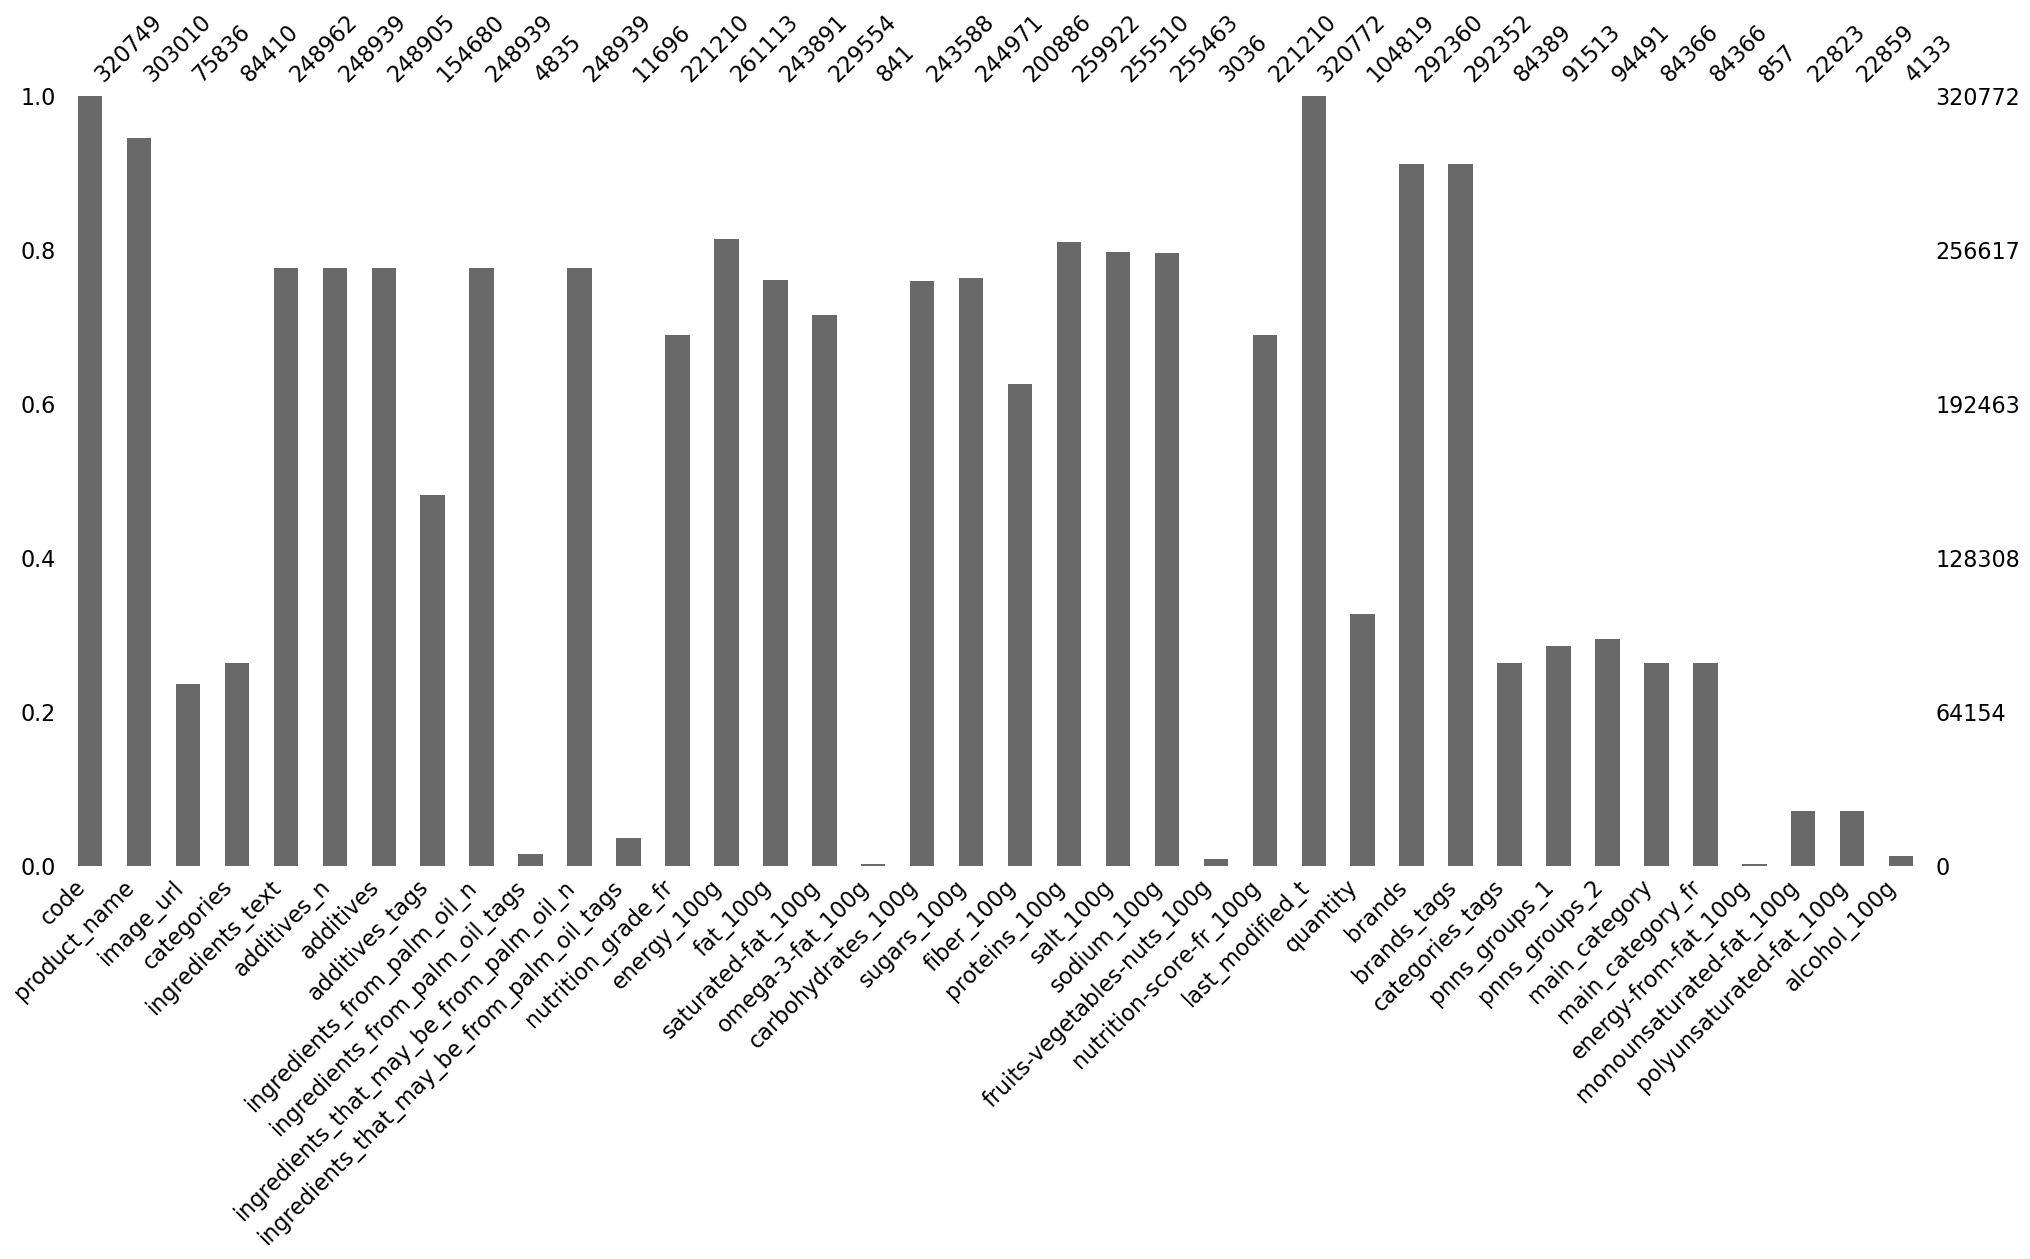

In [13]:
msno.bar(data)

On peut remarquer que beaucoupnde categories sont très vides. Certaines le sont surement car c'est une manière de marquer l'absence de quelquechose (très peu de valeurs dans "ingredients from palm oil" alors que ingredient text est assez remplis, cela signifie peut-être que pour beaucoup, pas de valeur = pas d'ingredients concernés.

Dans l'ensemble, le dataset semble assez bien remplis, surtout si une partie des valeurs peuvent être imputées facilement.

### Dentogramme des liens entre les colonnes

<AxesSubplot: >

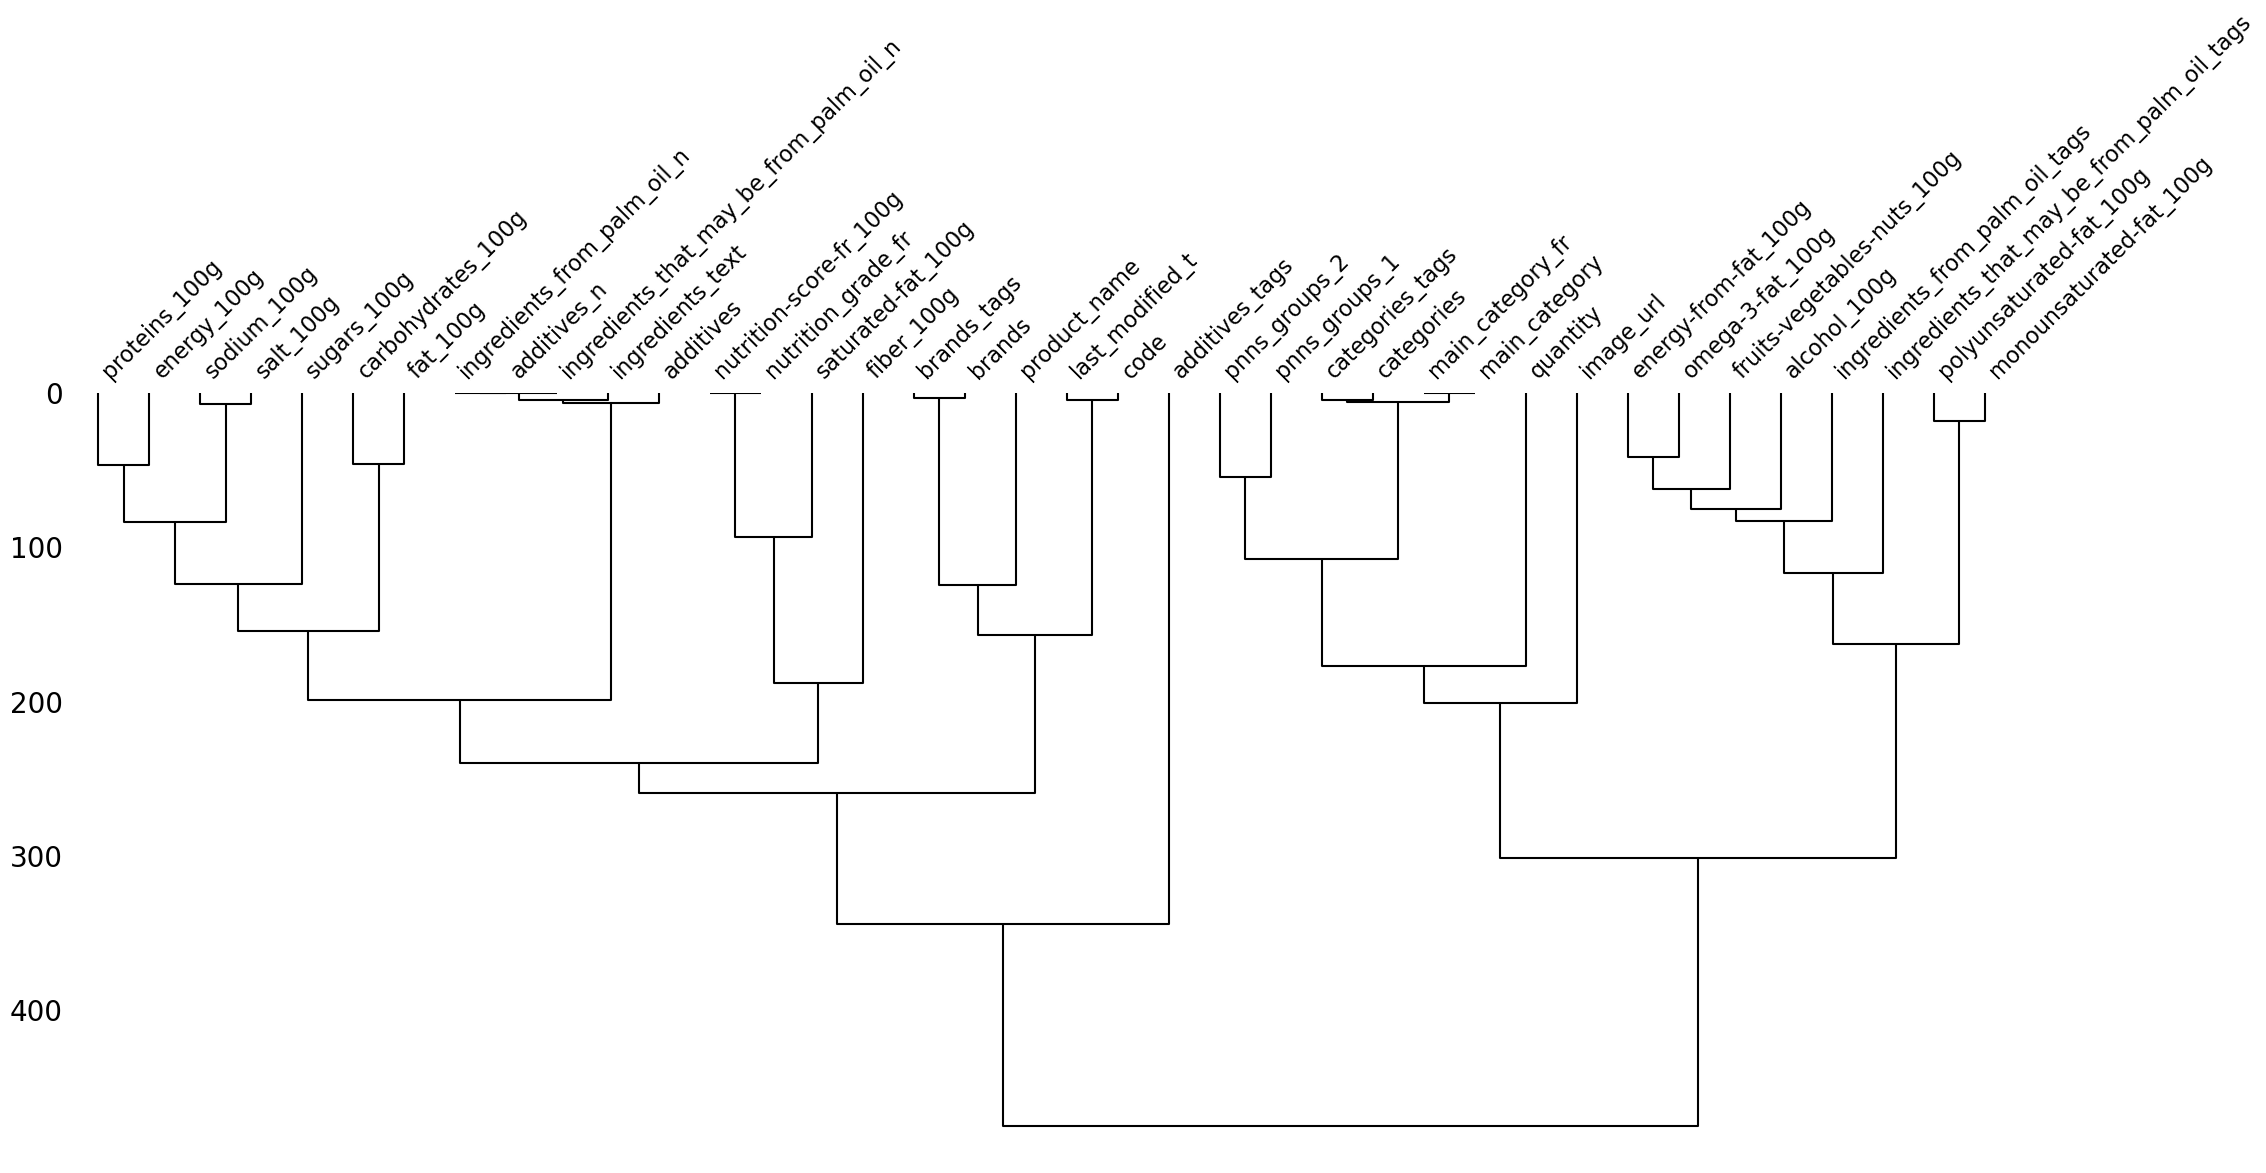

In [14]:
msno.dendrogram(data)

# Analyse des valeurs abérantes

## Suppression des lignes dans les valeurs abérantes pour les codes
Suppression des lignes quand il n'y a pas de code, ou que ce dernier n'est pas correcte (8, 12 ou 13 chiffres), et on ne garde que le code le plus recent

In [92]:
data = data.loc[data['code'].str.len().isin([8,12,13])]

In [93]:
data = data[data['code'].apply(lambda x: str(x).isdigit())]

In [94]:
data = data.sort_values(by='last_modified_t')

nb = len(data)
data = data[~data.duplicated(subset=['code'], keep="last")]

print("On a supprimé " + str(nb - len(data)) + " lignes")

On a supprimé 0 lignes


In [95]:
print("Tous les codes sont-ils bien uniques?")
print("Oui") if len(data.loc[data['code'].duplicated()]) == 0 else print("Non")

Tous les codes sont-ils bien uniques?
Oui


## Remplacement des unknow par des NaN

In [96]:
data[['pnns_groups_1', 'pnns_groups_2']] = data[['pnns_groups_1', 'pnns_groups_2']].replace('unknown', np.NaN)

## Remplacement des NaN par des " "

Pour les noms des produits, 

In [97]:
data['product_name'].fillna(value='', inplace=True)

Pour les tags alors qu'il y a le texte

In [98]:
mask = data['ingredients_text'].notna()

for c in ['additives_tags', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags']:
    data[c] = data.loc[mask, c].fillna('')

## Valeurs abérantes sur les informations nutritionelles
Affichage des valeurs abérantes pour la nouriture (l'énergie entre 0 et 3800kj, nutriscore entre -15 et 40, et le reste doit être entre 0 et 100)

In [99]:
for c in [c for c in data.columns if c.endswith('_100g')]:
    print(c)
    
    tmp = None
    
    if c.startswith('energy'):
        tmp = data.loc[~((data[c]<=3800) & (data[c]>=0) | data[c].isna()), ['code', 'product_name', c]]
    elif c.startswith('nutrition'):
        tmp = data.loc[~((data[c]<=40) & (data[c]>=-15) | data[c].isna()), ['code', 'product_name', c]]
    else:
        tmp = data.loc[~((data[c]<=100) & (data[c]>=0) | data[c].isna()), ['code', 'product_name', c]]
    
    if len(tmp) == 0:
        print('Rien\n')
    else:
        print(tmp.to_markdown(), '\n')

energy_100g
Rien

fat_100g
|        |          code | product_name           |   fat_100g |
|-------:|--------------:|:-----------------------|-----------:|
| 266641 | 4409266166288 | Poulet aux vermicelles |   -1.22415 |
| 192795 | 3083680767453 | Haricots beurre        |   -4.29564 | 

saturated-fat_100g
Rien

omega-3-fat_100g
Rien

carbohydrates_100g
Rien

sugars_100g
Rien

fiber_100g
Rien

proteins_100g
Rien

salt_100g
Rien

sodium_100g
Rien

fruits-vegetables-nuts_100g
Rien

nutrition-score-fr_100g
Rien

energy-from-fat_100g
|       |          code | product_name                    |   energy-from-fat_100g |
|------:|--------------:|:--------------------------------|-----------------------:|
| 62532 | 0051500239131 | Crisco All-Vegetable Shortening |                   3830 | 

monounsaturated-fat_100g
Rien

polyunsaturated-fat_100g
Rien

alcohol_100g
Rien



In [100]:
# Suppression des valeurs non comprises entre 0 et 100
for c in ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
         'omega-3-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
         'fruits-vegetables-nuts_100g', 'alcohol_100g']:
    data.loc[~((data[c]<=100) & (data[c]>=0)), [c]] = np.NaN

In [101]:
# Suppression des valeurs non comprises entre 0 et 3800
data.loc[~((data['energy_100g']<=3800) & (data['energy_100g']>=0)), ['energy_100g']] = np.NaN

In [102]:
# Réduction des valeurs > a 100, puis suppression si toujours pas entre 0 et 100
for c in ['salt_100g', 'sodium_100g']:    
    mask = ~(data[c]<=100)
    data.loc[mask, [c]] = data.loc[mask, [c]]/1000
    
    data.loc[~((data[c]<=100) & (data[c]>=0)), [c]] = np.NaN

## Valeurs nutritionelles incohérentes
Affichage des valeurs non cohérentes (kj avec le reste, sodium<sel, sucre<carbohydrate, somme des gras < fat)

In [103]:
for c1, c2 in [('salt_100g', 'sodium_100g'), ('carbohydrates_100g', 'sugars_100g'), ('fat_100g', 'saturated-fat_100g')]:
    mask = data[c1]<data[c2]
    tmp = data.loc[mask, ['code', 'product_name', c1, c2]]
    
    print(c1, 'vs', c2)
    if len(tmp) == 0:
        print('Rien\n')
    else:
        print(tmp, '\n')

salt_100g vs sodium_100g
Rien

carbohydrates_100g vs sugars_100g
                 code                                      product_name  \
281470       56094381                                      Indian tonic   
309129  8424766100224                                            Céleri   
253028  3760091729477  Nectar de citron vert du Brésil équitable et bio   
276952  5400210351735                              Mayonnaise aux oeufs   
196046  3165432560007                                       Sucre Glace   
...               ...                                               ...   
244622  3588400251965                                Rochers au praliné   
246426  3596710386505                          Instant gourmand passion   
249514  3700036901025                                    Figues séchées   
254226  3760159828654                                    Jus de grenade   
315871  8719189134094                                     Ice Tea Peach   

        carbohydrates_100g  sugars

Inversion de ces valeurs (pour le sel et le sodium, je préfère recalculer)

In [104]:
#('salt_100g', 'sodium_100g'), 
for c1, c2 in [('carbohydrates_100g', 'sugars_100g'), ('fat_100g', 'saturated-fat_100g')]:
    mask = data[c1]<data[c2]
    tmp = data[c1].copy()
    data.loc[mask, c1] = data[c2]
    data.loc[mask, c2] = tmp

## Calcul de certaines valeurs

Calcul du sodium et du sel

In [105]:
data.loc[~data['salt_100g'].isna(), 'sodium_100g'] = data.loc[~data['salt_100g'].isna(), 'salt_100g'] * 0.4
data.loc[~data['sodium_100g'].isna(), 'salt_100g'] = data.loc[~data['sodium_100g'].isna(), 'sodium_100g'] * 2.5

In [106]:
data[['code', 'product_name', 'salt_100g']].sort_values(by='salt_100g', ascending=False, na_position='last').head(5)

,code,product_name,salt_100g
256814,4001475112607,Meersalz mit Jod,100.0
245186,3596710220366,Sel de table fin,100.0
317238,8857107231774,Varech Croquant Taokaenoi,100.0
198796,3183280013766,Véritable sel de mer la baleine,100.0
214763,3263850052514,Fleur de sel de Guérande,100.0


Les _n

In [107]:
l = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']
data.fillna(0)

,code,product_name,image_url,categories,ingredients_text,additives_n,additives,additives_tags,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,...,quantity_unifie,quantity_valeur,quantity_unite,quantity_unite_enc,additives_0,additives_1,additives_2,additives_3,additives_4,categorie_level_3
249418,3700019510497,Attiéké,http://fr.openfoodfacts.org/images/products/37...,fr:couscous-de-manioc,Manioc 100%,0.0,[ manioc-100 -> fr:manioc-100 ] [ manioc ->...,,0.0,,...,500 g,500.0,g,153,196784.0,196783.0,0.0,0.0,0.0,0
202495,3229820781136,Poudre cristallisée à base de bouleau - Xylitol,http://fr.openfoodfacts.org/images/products/32...,en:sweeteners,Xylitol (100%),1.0,[ xylitol -> en:e967 -> exists -- ok ] [ ...,en:e967,0.0,,...,200 g,200.0,g,153,106423.0,0.0,0.0,0.0,0.0,0
252400,3760063335965,Sumac,http://fr.openfoodfacts.org/images/products/37...,en:condiments,Sumac (poudre),0.0,[ sumac -> fr:sumac ] [ poudre -> fr:poudre...,,0.0,,...,60 g,60.0,g,153,318178.0,262400.0,0.0,0.0,0.0,0
281470,56094381,Indian tonic,http://fr.openfoodfacts.org/images/products/56...,Sweetened beverages,"eau, sucre, sirop de glucose et fructose, diox...",2.0,[ eau -> fr:eau ] [ sucre -> fr:sucre ] [...,"en:e290,en:e330",0.0,,...,33 cl,33.0,cl,85,106712.0,314975.0,301295.0,301289.0,301137.0,0
112589,01922305,"Bonbons durs, cerise sauvage",http://fr.openfoodfacts.org/images/products/01...,Sweets,"Sucre, sirop de maïs, sirop de maïs a teneur é...",1.0,[ sucre -> fr:sucre ] [ sirop-de-mais -> fr...,en:e330,0.0,,...,32 g,32.0,g,153,314975.0,301499.0,300997.0,300890.0,301508.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176774,2000000045988,,0,0,0,0.0,0,0,0.0,0,...,0,0.0,0,420,0.0,0.0,0.0,0.0,0.0,0
258724,4008102000054,Edulcorant Liquide,http://fr.openfoodfacts.org/images/products/40...,en:tabletop-sweeteners,"eau, édulcorants cyclamate de sodium et saccha...",4.0,[ eau -> fr:eau ] [ edulcorants -> fr:edulc...,"en:e952,en:e330,en:e200,en:e957",0.0,,...,200 ml,200.0,ml,242,106712.0,108798.0,106423.0,91602.0,91601.0,0
255005,3760240720546,le bio de manon,0,0,"banane, huile de noix de coco, sucre de canne,...",0.0,[ banane -> fr:banane ] [ huile-de-noix-de-...,,0.0,,...,0,0.0,0,420,38438.0,162799.0,162797.0,162785.0,162113.0,0
230691,3396410047559,Chocolat Noir Costa Rica 75% De Cacao,0,Chocolate products,"pâte de cacao* (Costa Rica), sucre de canne*, ...",0.0,[ pate-de-cacao -> fr:pate-de-cacao ] [ pat...,,0.0,,...,70 g,70.0,g,153,247241.0,247225.0,246982.0,85145.0,85144.0,0


# Utilisation de ML et Clustering

In [31]:
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

## Apport possible des prédictions

In [32]:
nb = len(data.loc[data['categories_tags'].notna() & data['energy_100g'].isna()])
print("Il y a " + str(nb) + " lignes de categories qui sont pleines alors que energy est vide.")

Il y a 20910 lignes de categories qui sont pleines alors que energy est vide.


In [33]:
nb = len(data.loc[data['categories_tags'].isna() & data['energy_100g'].notna()])
print("Il y a " + str(nb) + " lignes de energy qui sont pleines alors que categories est vide.")

Il y a 194931 lignes de energy qui sont pleines alors que categories est vide.


## Mise en forme des données

### Faciliter l'interprétation de Quantity
Séparation de quantity en sa valeur, sa valeur normée et l'unité

In [34]:
data['quantity'] = data['quantity'].str.lower()

In [35]:
listeUnite = data.loc[data['quantity'].notna(), 'quantity'].str.extract(r'([a-z]+)', flags=re.I, expand=True).stack()

In [36]:
print("Nombre d'unites differentes :", len(listeUnite.value_counts()))
print("Voici les valeurs les plus représentées :")
listeUnite.value_counts().head(10)

Nombre d'unites differentes : 595
Voici les valeurs les plus représentées :


g          72481
l           6340
ml          6239
cl          4442
kg          4073
x           1359
gr          1061
oz           926
litre        396
grammes      304
dtype: int64

In [37]:
def convert_unit(txt, get_u=None):
    if txt is np.NaN:
        return np.NaN
    
    tradUnit = {
        'gr':'g',
        'grs':'g',
        'gm':'g',
        'gms':'g',
        'litre':'l',
        'liter':'l',
        'litro':'l',
        'litros':'l',
        'liters':'l',
        'litres':'l',
        'litters':'l',
        'litter':'l',
        'littes':'l',
        'gallon':'gal',
        'galon':'gal',
        'gallons':'gal',
        'galons':'gal',
        'lt':'l',
        'lts':'l',
        'grammes':'g',
        'grams':'g',
        'gram':'g',
        'grm':'g',
        'gramms':'g',
        'gramme':'g',
        'gramm':'g',
        'gramos':'g',
        'poids':'g',
        'kilos':'kg',
        'kilo':'kg',
        'k':'kg',
        'lbs':'lb',
        'livre':'lb',
        'livres':'lb',
        'ltr':'l',
        'ltrs':'l'
    }
    for m, u in re.findall(r'([0-9]+)\ *([a-z]+)', txt):
        if u in tradUnit:
            u = tradUnit[u]
        
        if get_u == 'm':
            return m
        elif get_u == 'u':
            return u
        else:
            return m + ' ' + u

Application de la fonction pour créer trois nouvelles collonnes selon la valeur présente dans _quantity_ : l'unité (normalisée), la valeur, et la combinaison des deux. 

In [38]:
data['quantity_unifie'] = data['quantity'].apply(convert_unit)
data['quantity_valeur'] = pd.to_numeric(data['quantity'].apply(lambda x : convert_unit(x, 'm')))
data['quantity_unite'] = data['quantity'].apply(lambda x : convert_unit(x, 'u'))

In [39]:
listeColonesAlgo += ['quantity_unite', 'quantity_valeur', 'quantity_unifie']

Enfin, la colonne des unités est encodé pour être interprétable par les autres outils

In [40]:
# Encodage des unites
enc = LabelEncoder().fit(data['quantity_unite'])
data['quantity_unite_enc'] = pd.to_numeric(enc.transform(data['quantity_unite']))

In [41]:
listeColonesAlgo += ['quantity_unite_enc']

In [42]:
data['quantity_unite'].unique()

array(['g', 'cl', nan, 'ml', 'kg', 'l', None, 'tasses', 'x', 'tranches',
       't', 'portions', 'pi', 'sachets', 'godets', 'fruit', 'oeufs', 'oz',
       'boite', 'pots', 'dosettes', 'patch', 'biscuits', 'drag',
       'infusettes', 'ge', 'capsules', 'dl', 'capsule', 'gauffrettes',
       'fl', 'ounces', 'unit', 'bolsa', 'bo', 'units', 'magret',
       'tablette', 'caps', 'gaufres', 'escalopes', 'db', 'saucisses',
       'pcs', 'pills', 'theezakjes', 'cuisse', 'unidades', 'eggs',
       'pieza', 'pound', 'paquets', 'barritas', 'lb', 'uova', 'piezas',
       'ud', 'pz', 'tartelettes', 'gousses', 'unidad', 'bouteilles',
       'duck', 'pint', 'b', 'mini', 'fruits', 'chicken', 'barquette',
       'mg', 'dadi', 'p', 'pizze', 'de', 'comprim', 'sticks', 'filter',
       'porciones', 'ampoules', 'cabezas', 'tea', 'bag', 'packs',
       'breakfast', 'porzioni', 'pack', 'pieces', 'can', 'box', 'sabl',
       'pints', 'personne', 'chops', 'baskets', 'sheets', 'steaks',
       'steak', 'stems', 

In [43]:
# Création d'une valeur stantard mais s'est avéré inutile
'''
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'g', 'quantity_valeur']
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'kg', 'quantity_valeur'] * 1000
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'mg', 'quantity_valeur'] / 1000
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'cl', 'quantity_valeur'] * 10
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'dl', 'quantity_valeur'] * 100
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'ml', 'quantity_valeur']
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'l', 'quantity_valeur'] * 1000

data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'fl', 'quantity_valeur'] * 29.5
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'gal', 'quantity_valeur'] * 4546
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'oz', 'quantity_valeur'] * 29.5
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'lb', 'quantity_valeur'] * 453.6

data['quantity_valeur_std'] = data.loc[data['quantity_valeur_std'].isna(), 'quantity_valeur']
'''

"\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'g', 'quantity_valeur']\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'kg', 'quantity_valeur'] * 1000\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'mg', 'quantity_valeur'] / 1000\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'cl', 'quantity_valeur'] * 10\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'dl', 'quantity_valeur'] * 100\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'ml', 'quantity_valeur']\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'l', 'quantity_valeur'] * 1000\n\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'fl', 'quantity_valeur'] * 29.5\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'gal', 'quantity_valeur'] * 4546\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'oz', 'quantity_valeur'] * 29.5\ndata['quantity_valeur_std'] = dat

### Mise en forme de categories

Analyse des categories et pnns

In [44]:
data.loc[data['pnns_groups_1'].isna() ^ data['pnns_groups_2'].isna(), ['categories_tags', 'pnns_groups_1', 'pnns_groups_2']]

,categories_tags,pnns_groups_1,pnns_groups_2
209249,"en:beverages,en:alcoholic-beverages,en:hard-li...",NaN,Alcoholic beverages
283103,"en:beverages,en:alcoholic-beverages,en:hard-li...",NaN,Alcoholic beverages
271038,"en:beverages,en:alcoholic-beverages,en:hard-li...",NaN,Alcoholic beverages
196980,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,Alcoholic beverages
220465,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,Alcoholic beverages
...,...,...,...
315328,"en:beverages,en:alcoholic-beverages,en:beers",NaN,Alcoholic beverages
253362,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,Alcoholic beverages
281039,"en:beverages,en:alcoholic-beverages,en:beers",NaN,Alcoholic beverages
253361,"en:beverages,en:alcoholic-beverages,en:artisan...",NaN,Alcoholic beverages


In [45]:
data.loc[data['categories_tags'].isna() & (data['pnns_groups_1'].notna() | data['pnns_groups_2'].notna()), ['categories_tags', 'pnns_groups_1', 'pnns_groups_2']]

,categories_tags,pnns_groups_1,pnns_groups_2


In [46]:
# data.loc[data['pnns_groups_2'].notna(), 'categories_tags'] = data.loc[data['pnns_groups_2'].notna(), 'pnns_groups_2']

Dégroupement de la variable _categories_ pour pouvoir choisir plus facilement le niveau de précision de cette colonne

In [47]:
dataCat = data.loc[:, 'categories_tags'].str.split(',', expand = True)

In [48]:
dataCat.columns = ['categorie_level_' + str(x) for x in dataCat.columns]

In [49]:
dataCatFill = dataCat.ffill(axis=1)

In [50]:
@interact
def show_categories(column=list(dataCatFill.columns), PNNS=True):
    if PNNS:
        tmp = pd.concat([dataCatFill.loc[data['pnns_groups_2'].isna(), column], data['pnns_groups_2']]).value_counts()
    else:
        tmp = dataCatFill[column].value_counts()
    print("Nombre de valeurs uniques : ", len(tmp))
    print(tmp.head(10))

interactive(children=(Dropdown(description='column', options=('categorie_level_0', 'categorie_level_1', 'categ…

### Ajout de colonnes donnants le xeme ingredient

In [51]:
listAdditivesMatch = data.loc[:, 'additives'].str.extractall(r'\-\> +[a-z]+\:([^\ 0-9]+)')

In [52]:
tmp = listAdditivesMatch.value_counts()
print("Nombre de valeurs uniques :", len(tmp))
tmp.head(10)

Nombre de valeurs uniques : 353018


e        513081
salt     125606
sugar    102770
water     86500
oil       86449
flour     75842
fd-c      73649
milk      51284
sel       47192
syrup     43093
dtype: int64

In [53]:
# enc = LabelEncoder().fit(list(listAdditivesMatch[0]) + [np.NaN])

In [54]:
enc = LabelEncoder().fit(listAdditivesMatch[0].unique())

In [55]:
for i in range(5):
    data['additives_'+str(i)] = listAdditivesMatch.loc[:, i, :]
    mask = data['additives_'+str(i)].notna()
    data.loc[mask, 'additives_'+str(i)] = enc.transform(data.loc[mask, 'additives_'+str(i)])
    data['additives_'+str(i)] = data['additives_'+str(i)].astype('float')
    listeColonesAlgo += ['additives_'+str(i)]

In [56]:
'''
for i in range(5):
    data = data.drop('additives_'+str(i), axis=1)
    listeColonesAlgo.pop()
'''

"\nfor i in range(5):\n    data = data.drop('additives_'+str(i), axis=1)\n    listeColonesAlgo.pop()\n"

## Prédiction des valeurs nutritionelles
### Test pour une colonne avec un niveau de précision

In [57]:
level = 'categorie_level_3'
col = 'energy_100g'
colNew = col+'_mean'

In [58]:
dataGroup = data.copy()
dataGroup[level] = dataCatFill[level]

In [59]:
tmp = dataGroup[[level, col]].groupby(by=level).count()
nb = int((tmp<1).sum())
print("Nombre de categories avec une seule valeur ou moins :", nb)
print("Soit", int(100*nb/len(tmp)), "% des categories")

Nombre de categories avec une seule valeur ou moins : 1723
Soit 26 % des categories


On regroupe les lignes par groupe et on leur applique une fonction (med, mex, min, avg)

In [60]:
mask = dataGroup[level].notna()

dataCompare = pd.DataFrame(columns=['data', 'methode'])

for methode, nom in [(pd.Series.median, 'median'), (pd.Series.mean, 'mean'), (pd.Series.min, 'min'), (pd.Series.max, 'max')]:
    tmpGroup = dataGroup[[level, col]].groupby(by=level).agg(methode)
    
    mask = dataGroup[level].notna()
    dataGroup.loc[mask,colNew] = list(tmpGroup.loc[dataGroup.loc[mask,level], col])
    
    tmp =  pd.DataFrame(columns=['data', 'methode'])
    tmp['data'] = list((dataGroup[col] - dataGroup[colNew]).abs())
    tmp['methode'] = [nom]*len(dataGroup)
    dataCompare = pd.concat([dataCompare, tmp])
    
    '''
    print("Avec la méthode "+nom+" on obtient :")
    print(tmp['data'].describe())
    print('\n')
    '''

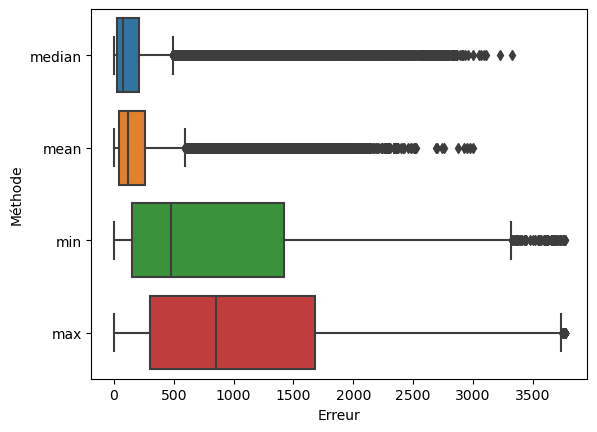

In [61]:
sns.boxplot(data=dataCompare, x='data', y='methode')

plt.ylabel("Méthode")
plt.xlabel("Erreur")

plt.show()

### Application de l'algorithme
Estimation de toutes les données nutritionelles selon la mediane de sa categorie

In [62]:
level = 'categorie_level_3'

dataGroup = data.copy()
dataGroup[level] = dataCatFill[level]

for col in ['energy_100g','fat_100g','saturated-fat_100g','omega-3-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g',
'proteins_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g','nutrition-score-fr_100g']:
    colNew = col+'_mean'

    tmpGroup = dataGroup[[level, col]].groupby(by=level).median()

    mask = dataGroup[level].notna() & dataGroup[col].isna()
    data.loc[mask,col] = list(tmpGroup.loc[dataGroup.loc[mask,level], col])

## Prédiction des categories

### Tests des méthodes disponibles

Sélection de la colonne à prédire, on récupère les colonnes contenant des valeurs chiffées, on limite les valeurs NaN, et enfin on en fait deux sets (entrainement et test)

In [63]:
# categories, categories_tags, main_category, main_category_fr, categorie_level_4
columnPredict = 'categorie_level_3'

listeTmp = data.copy()
listeTmp[columnPredict] = dataCatFill[columnPredict]
# Remplacement (en option) des categories classiques par PNNS
listeTmp.loc[data['pnns_groups_2'].notna(), columnPredict] = data.loc[data['pnns_groups_2'].notna(), 'pnns_groups_2']
listeTmp = listeTmp.dropna(subset=columnPredict)


# Liste des colonnes numériques avec plus de 40% de remplissage
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)
listeColumns = list(listeTmp[listeColumns].isna().mean().loc[lambda x : x < 0.6].index)

n = len(listeTmp)
listeTmp = listeTmp[listeColumns + [columnPredict]].dropna()
print(str( 100*(n - len(listeTmp))/n) + "% elements supprimes")
print(len(listeTmp), 'lignes')
print(len(listeColumns), 'colonnes')

X, y = listeTmp[listeColumns], listeTmp[columnPredict]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

56.35495026560662% elements supprimes
36726 lignes
21 colonnes


In [64]:
# Encodage des categories
enc = LabelEncoder().fit(listeTmp[columnPredict])
ytrain = enc.transform(ytrain)
ytest = enc.transform(ytest)

#### K-NN

In [65]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.415736


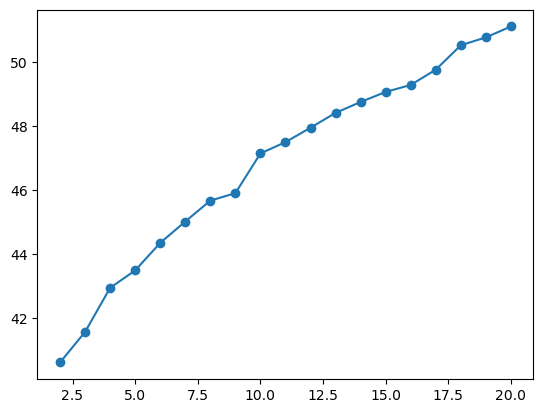

In [66]:
errors = []
for k in range(2,len(listeColumns)):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,len(listeColumns)), errors, 'o-')
plt.show()

#### Arbre de décision

In [67]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(xtrain, ytrain)
error = 1 - clf.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.168663


#### Foret d'arbres de décision

In [68]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(xtrain, ytrain)
error = 1 - clf.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.118840


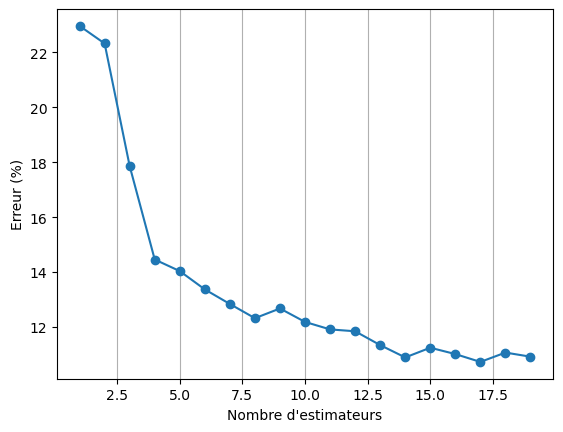

In [69]:
errors = []
for k in range(1,20):
    clf = RandomForestClassifier(n_estimators=k)
    clf = clf.fit(xtrain, ytrain)
    errors.append(100*(1 - clf.score(xtest, ytest)))
plt.plot(range(1, len(errors)+1), errors, 'o-')
plt.grid(axis='x')

plt.ylabel("Erreur (%)")
plt.xlabel("Nombre d'estimateurs")

plt.show()

### Application de l'algorithme

In [70]:
columnPredict = 'categorie_level_3'

data[columnPredict] = dataCatFill[columnPredict]
data.loc[data['pnns_groups_2'].notna(), columnPredict] = data.loc[data['pnns_groups_2'].notna(), 'pnns_groups_2']

listeTmp = data.loc[~data[columnPredict].isna()]

# Liste des colonnes numériques
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)
listeColumns = list(listeTmp[listeColumns].isna().mean().loc[lambda x : x < 0.6].index)

n = len(listeTmp)
listeTmp = listeTmp[listeColumns + [columnPredict]].dropna()
print(str( 100*(n - len(listeTmp))/n) + "% elements supprimes")
print(len(listeTmp), 'lignes')
print(len(listeColumns), 'colonnes')

X, y = listeTmp[listeColumns], listeTmp[columnPredict]

56.35495026560662% elements supprimes
36726 lignes
21 colonnes


In [71]:
# Encodage des categories
enc = LabelEncoder().fit(y)
y = enc.transform(y)

In [72]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, y)

In [73]:
listeTmp = data.loc[data[columnPredict].isna(), listeColumns]
print("Nombre de lignes sans categorie :", len(listeTmp))
listeTmp = listeTmp.dropna()
print("Nombre de lignes pouvant être prédites :", len(listeTmp))

Nombre de lignes sans categorie : 233514
Nombre de lignes pouvant être prédites : 29


In [74]:
listeTmp[columnPredict] = enc.inverse_transform(clf.predict(listeTmp))

In [75]:
#listeTmp[['code', 'product_name']] = data.loc[listeTmp.index, ['code', 'product_name']]
#listeTmp[ ['code', 'product_name', columnPredict]].head(20)

In [76]:
data[columnPredict] = listeTmp[columnPredict]

In [77]:
data.loc[listeTmp.index, ['code', 'product_name', columnPredict]].head(20)

,code,product_name,categorie_level_3
219175,3270160590193,6 Fagots de haricots verts,Cereals
178922,20250515,Aceto balsamico di modena,Sweets
226830,3347437067310,Bûchette d'epeautre nappee de chocolat,Biscuits and cakes
246707,3596710401840,Macédoine de Légumes,One-dish meals
197466,3175681177543,Modérateur d'Appétit,Biscuits and cakes
238192,3560070371600,Pizza pate fine tonno,en:frozen-pizzas
270483,5000488108354,Rescue pastilles,Non-sugared beverages
270922,5010338015817,Feuille De Riz Pour Nem,Cereals
201616,3222475983290,BIO Galette Maïs Chocolat noir,Cereals
215614,3263852173019,Cacahuetes Au Chocolat Franprix,Sweets


In [78]:
data['categories'] = dataCatFill[columnPredict]
data.loc[data['pnns_groups_2'].notna(), 'categories'] = data.loc[data['pnns_groups_2'].notna(), 'pnns_groups_2']
data.loc[listeTmp.index, 'categories'] = data.loc[listeTmp.index, columnPredict]

## Test Iterative inputer

In [79]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import *

In [80]:
# Liste des colonnes numériques
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)
if 'sodium_100g' in listeColumns : listeColumns.remove('sodium_100g')

In [81]:
# Création d'un dataset troué aléatoirement
listeColumnsHole = listeColumns[:-7]
maskHole = pd.DataFrame(np.random.randint(0,100,data[listeColumnsHole].shape), columns=listeColumnsHole, index=data.index) < 10
dataHole = data[listeColumnsHole].copy()
dataHole = dataHole.mask(maskHole)
dataHole

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
249418,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202495,1.0,0.0,0.0,1000.0,0.5,0.1,100.0,0.5,0.5,NaN,0.01270,NaN,2.0
252400,0.0,0.0,0.0,700.0,3.4,0.4,13.0,2.8,NaN,3.55,2.16728,NaN,NaN
281470,NaN,0.0,0.0,156.0,0.0,0.0,8.9,9.0,0.0,0.00,0.01020,2.0,NaN
112589,1.0,0.0,0.0,1591.0,0.5,0.4,88.2,62.0,0.0,0.50,0.03000,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258724,NaN,NaN,0.0,2.4,0.0,0.0,0.1,0.1,0.0,NaN,1.35000,NaN,5.0
255005,0.0,0.0,0.0,2146.0,33.6,29.9,58.4,35.3,NaN,2.30,0.00000,NaN,23.0
230691,0.0,0.0,NaN,2404.0,44.0,27.0,30.0,24.0,9.0,10.00,0.03000,13.5,22.0


In [82]:
imp_mean = IterativeImputer(sample_posterior=True, initial_strategy='median')
imp_mean.fit(dataHole)

IterativeImputer(initial_strategy='median', sample_posterior=True)

In [83]:
dataHolePred = imp_mean.transform(dataHole)

In [84]:
dataHoleReal = data[listeColumnsHole].copy().mask(~maskHole)
dataHolePred = pd.DataFrame(dataHolePred, columns=dataHole.columns, index=dataHole.index).mask(dataHoleReal.isna())
dataHoleReal = dataHoleReal.mask(dataHolePred.isna())

listeScore = []
for c in dataHolePred.columns:
    score = r2_score(dataHoleReal[c].dropna(), dataHolePred[c].dropna())
    listeScore += [(c, score)]
    print("Pour la colonne", c, ", l'erreur R² est de :", str(score))

Pour la colonne additives_n , l'erreur R² est de : -0.6777305041475734
Pour la colonne ingredients_from_palm_oil_n , l'erreur R² est de : -1.0038094550666736
Pour la colonne ingredients_that_may_be_from_palm_oil_n , l'erreur R² est de : -0.74879744206738
Pour la colonne energy_100g , l'erreur R² est de : 0.7645282841656923
Pour la colonne fat_100g , l'erreur R² est de : 0.7294583275246233
Pour la colonne saturated-fat_100g , l'erreur R² est de : 0.10469377156780624
Pour la colonne carbohydrates_100g , l'erreur R² est de : 0.6582509784875602
Pour la colonne sugars_100g , l'erreur R² est de : 0.1834478307896107
Pour la colonne fiber_100g , l'erreur R² est de : -0.4337980731600286
Pour la colonne proteins_100g , l'erreur R² est de : -0.2070411142734836
Pour la colonne salt_100g , l'erreur R² est de : -1.0858444188218872
Pour la colonne fruits-vegetables-nuts_100g , l'erreur R² est de : -0.2749806989046768
Pour la colonne nutrition-score-fr_100g , l'erreur R² est de : 0.364833867319433


### Application de l'algorithme

In [85]:
# Liste des colonnes numériques
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)

In [86]:
imp_mean = IterativeImputer(sample_posterior=True, initial_strategy='median')
imp_mean.fit(data[listeColumns])

IterativeImputer(initial_strategy='median', sample_posterior=True)

In [87]:
# On ne garde que les lignes avec moins de 10% de valeurs NaN
mask = data[listeColumns].isna().mean(axis=1) < 0.1
dataII = data.loc[mask, listeColumns]
print("On ne garde que", len(dataII), "lignes.")

On ne garde que 184857 lignes.


In [88]:
dataIIPred = pd.DataFrame(imp_mean.transform(dataII), columns=dataII.columns, index=dataII.index)

In [89]:
# Liste des colonnes avec un bon R² score
listeColumnsInteressantes = [c for c, s in listeScore if s>0.7]
print(listeColumnsInteressantes)

['energy_100g', 'fat_100g']


In [90]:
data.loc[mask, listeColumnsInteressantes] = dataIIPred[listeColumnsInteressantes]

# Completion des dernières colonnes

Grade nutriscore

In [91]:
def to_grade(x):
    if x<0:
        return 'a'
    elif x<3:
        return 'b'
    elif x<11:
        return 'c'
    elif x<19:
        return 'd'
    else:
        return 'e'

In [108]:
mask = data['nutrition-score-fr_100g'].notna() & data['nutrition_grade_fr'].isna()

In [109]:
data.loc[mask, 'nutrition_grade_fr'] = data.loc[mask, 'nutrition-score-fr_100g'].apply(to_grade)

## Ajout de colonnes personnalisées

### Nombre d'ingredients

In [110]:
data['ingredients_n'] = data['additives'].str.count('\[')

### Score additifs final

In [111]:
def to_score_additives(txt):
    
    if txt is None or txt is np.nan : return None
    txt = str(txt)
    if txt == '' : return 0
    
    total = 0
    
    for e in txt.replace('en:', '').split(','):
        if e not in listeAdditifs:
            e = 'e666'
        total += listeAdditifs[e]
    
    return total

In [112]:
data['additives_score'] = data['additives_tags'].apply(to_score_additives)

# On ne garde que les colonnes utiles

In [113]:
data = data[listeColonesClient + 
            [c for c in listeColonesScore if c not in listeColonesClient] + 
            ['additives_score', 'ingredients_n']]

# FIN

In [114]:
data.to_csv('./data/data_clean.csv')

<AxesSubplot: >

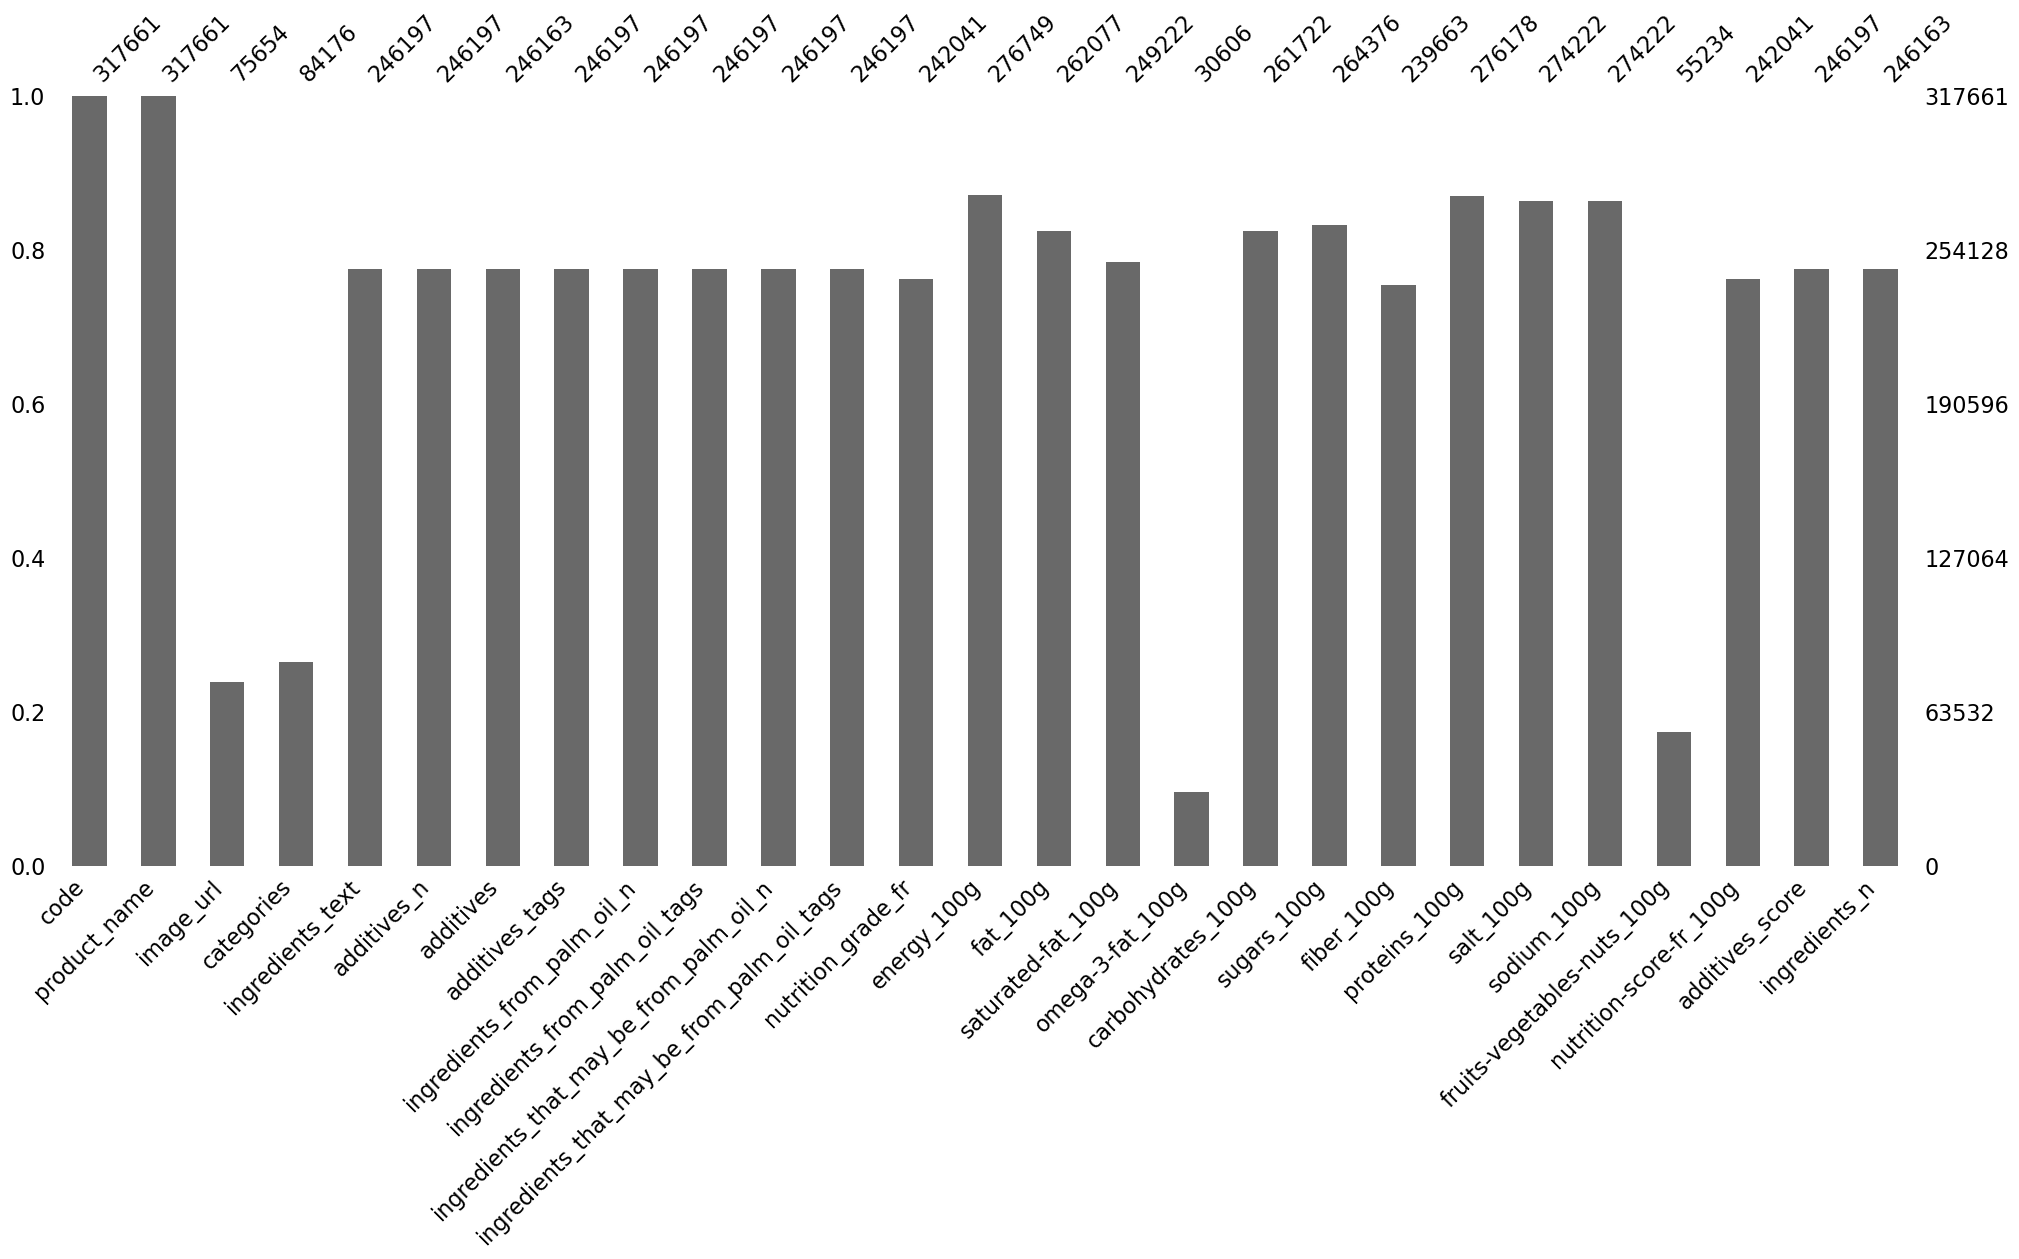

In [115]:
msno.bar(data)

<AxesSubplot: >

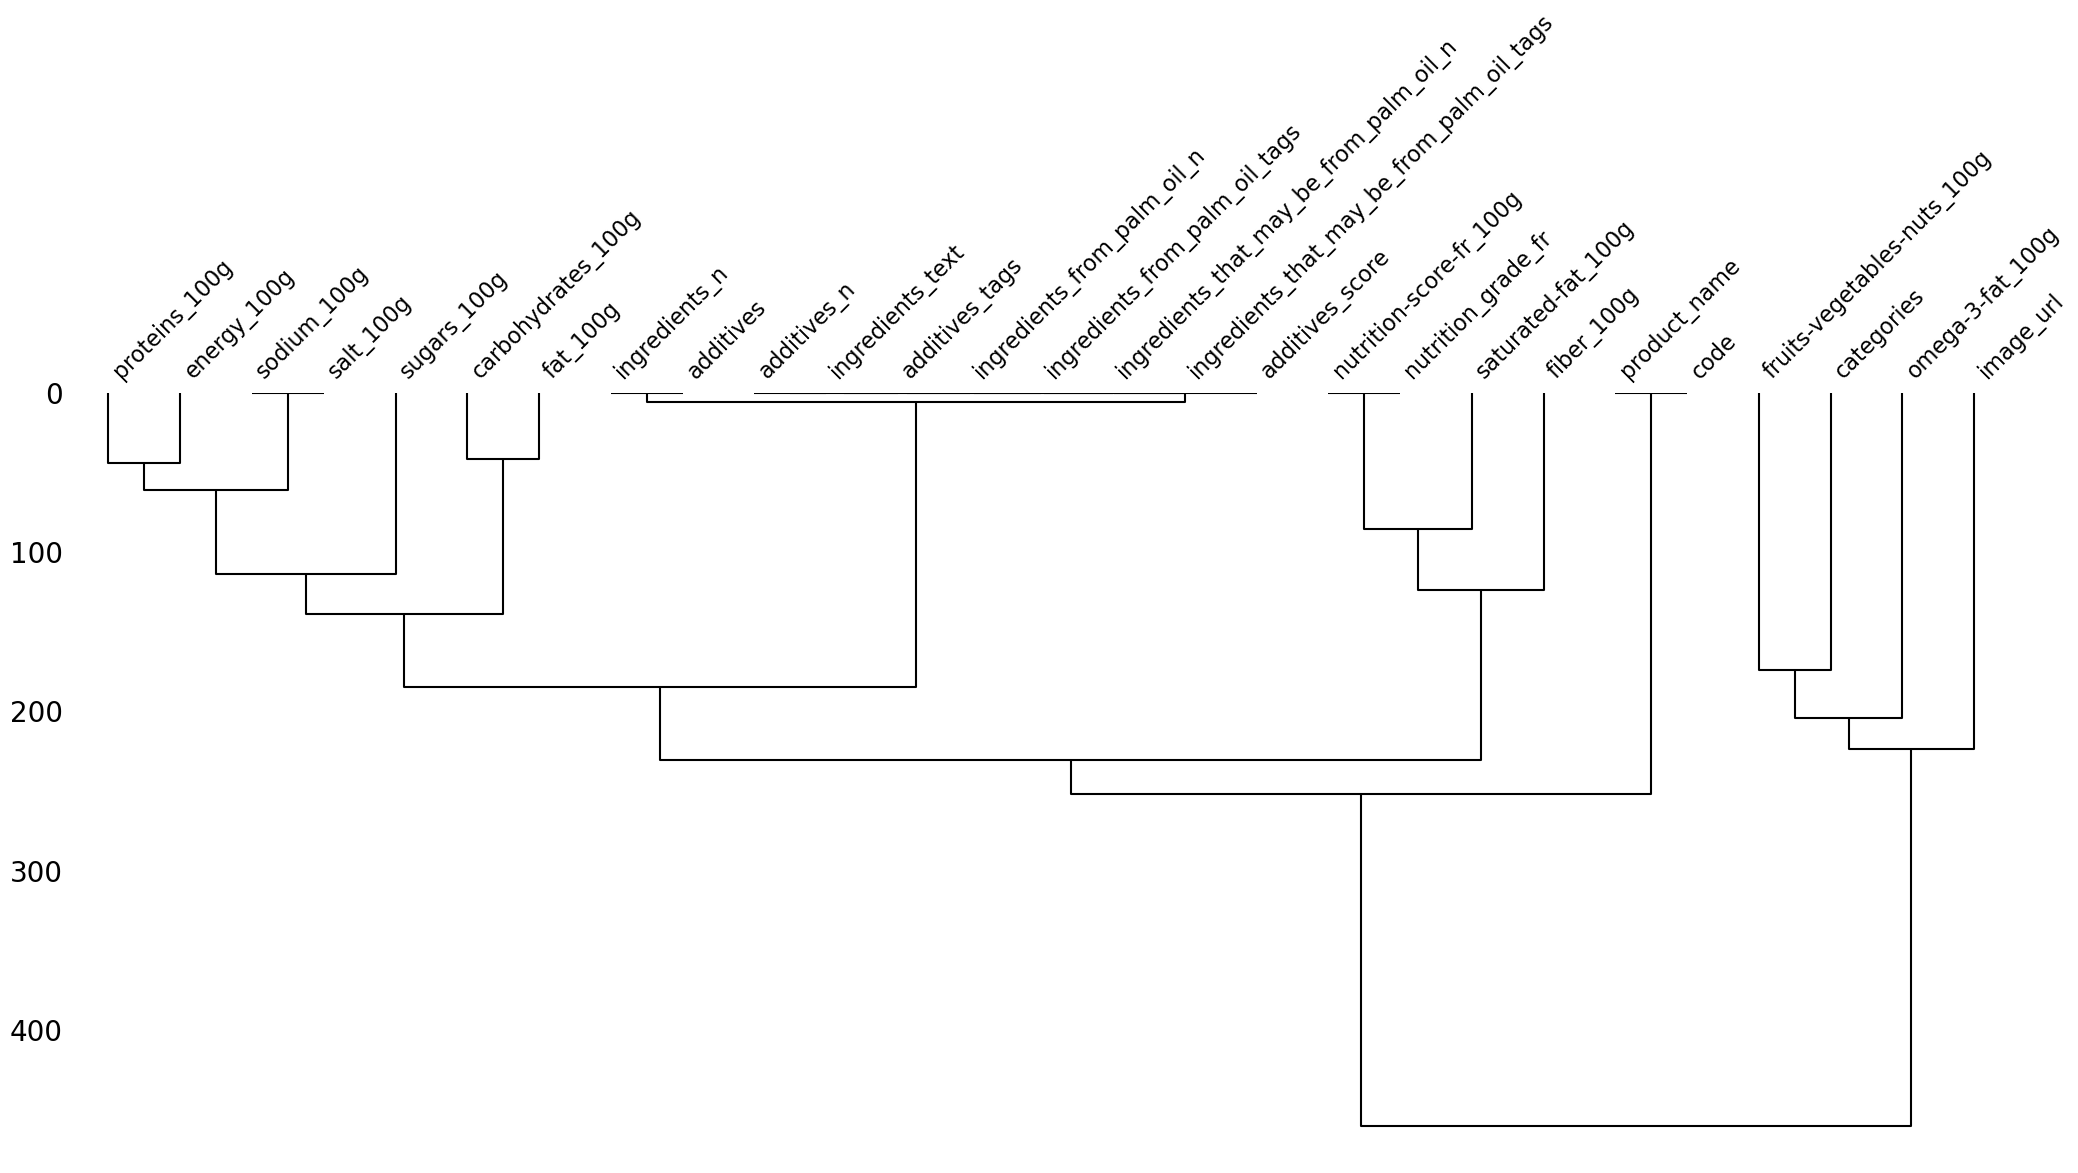

In [116]:
msno.dendrogram(data)

## Verification de l'existence d'additifs

In [101]:
mauvais_additifs = set()
for i in data.index:
    val = data.loc[i, 'additives_tags']
    if val is np.NaN:
        continue
        
    listeA = data.loc[i, 'additives_tags'].split(',')
    for j in range(len(listeA)):
        a = listeA[i][3:]
        if a not in additifs:
            if a[3:-1] not in additifs and a[3:-2] not in additifs:
                pass
            mauvais_additifs.add(a[3:])
            
print(mauvais_additifs)

IndexError: list index out of range

In [ ]:
@interact
def show_articles_more_than(column=[c for c, d in zip(data.columns, data.dtypes) if d != 'object']):
    return data[column].plot.box()

In [ ]:
# Fonction pour détecter combien de colonnes contiennent une valeurs quand l'autre n'en a pas
def same_filling(data, c1, c2, affiche=True):
    mask  = data.loc[:, c1].isna()
    mask ^= data.loc[:, c2].isna()
    
    if not affiche:
        return mask
    
    nb = mask.sum()
    
    print("\nIl y a en tout", nb, "lignes différentes entre", c1, "et", c2, ".")
    if nb>0:
        dataSelect = data.loc[mask]
        print("Sur ces colonnes,", c1, "contient", dataSelect[c1].notna().sum(), "valeurs.")
        print("Et", c2, "contient", dataSelect[c2].notna().sum(), "valeurs.\n")
        print(dataSelect.loc[:, [c1, c2]].head(5))

In [ ]:
# Vérification des incohérences entre les colonnes avec et sans tag
for c in list(data.columns):
    if c.endswith('_tags') and c[:-5] in data.columns:
        same_filling(data, c, c[:-5])

In [ ]:
# Liste des colonnes avec tag
listeTags = pd.Series(data.columns).loc[data.columns.str.endswith('_tags')]

In [ ]:
# Suppression des lignes sans code (impossible à utiliser)
dataClean = data.loc[~dataClean['code'].isna()]
# Et vérification que les codes sont bien uniques (True  = oui)
len(dataClean.loc[dataClean['code'].duplicated()]) == 0

In [ ]:
# Reformate additives et remplis additives_tags
dataClean['additives_tags'] = dataClean['additives'].str.replace(r'\[[^\]>]*> ([a-z]{2}:[a-z0-9\-]+)[^\]]*\] *', r'\1,', regex=True)
dataClean['additives'] = dataClean['additives'].str.replace(r'\[ *([a-z0-9\-]+)[^\[]*', r'\1,', regex=True)

In [ ]:
# Met à NaN toutes les lignes dont tag est NaN (car c'est que la valeur nontag n'est pas valide)
for c1 in listeTags:
    c2 = c1[:-5]
    dataClean.loc[dataClean[c1].isna(), c2] = np.NaN
    if c2 in ['brands']: #Et pour brands on peut même faire l'inverse
        dataClean.loc[dataClean[c2].isna(), c1] = np.NaN

In [ ]:
# Normalise un texte pour en faire un tag
def to_tag(s):
    s = s.lower().strip()
    s = re.sub(r"( +|\')",'\-', s)
    s = re.sub(r'[^\w\s\-]','', s)
    s = unidecode(s)
    return s

In [ ]:
tagToText = {'huile-de-palme': 'Huile de palme'}

# Transforme un tag en texte
def to_text(s):
    oldS = s
    if s in tagToText:
        return tagToText[s]
    
    s = s.replace('-', ' ')
    s = s.capitalize()
    tagToText[oldS] = s
    return s

In [ ]:
# Ajout de la version humaine des tags
for c1 in ['ingredients_that_may_be_from_palm_oil_tags', 'ingredients_from_palm_oil_tags']:
    c2 = c1[:-5]
    mask = same_filling(dataClean, c1, c2, affiche=False)
    
    dataClean.loc[mask, c2] = dataClean.loc[mask, c1].str.split(',').apply(lambda t : ', '.join([to_text(x) for x in t]))

In [ ]:
dataClean.columns

In [ ]:
for c in dataClean.columns:
    if c.endswith('_100g'):
        dataClean[c]

In [ ]:
#dataClean['energy_100g'].plot(kind='box')

min_threshold,max_threshold = dataClean['energy_100g'].quantile([0.01,0.99])
print(min_threshold,max_threshold)

dataClean[(dataClean['energy_100g']<min_threshold)|(dataClean['energy_100g']>max_threshold)][['code', 'fat_100g','energy_100g']].sort_values(by='energy_100g')

In [ ]:
dataClean.loc[:, 'ingredients_from_palm_oil'].str.split(',', expand = True).stack().value_counts().plot(kind='barh', logx=True)

In [ ]:
dataClean['ingredients_that_may_be_from_palm_oil_tags'].str.split(',', expand = True).stack().value_counts().plot(kind='barh', logx=True)

In [ ]:
dataClean.loc[dataClean['brands_tags'].fillna('').str.contains(','), ['brands_tags', 'brands']]